In [1]:
import joblib

from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import linear_model

from data import load_train_test_sets
from model import evaluate_model, create_pipeline
%matplotlib inline

## Define y_target and split train/test dataset

In [2]:
import pandas as pd

df = pd.read_csv('../data/clean_dataset.csv')

In [3]:
X_train, X_test, y_train, y_test = load_train_test_sets()

Proportion of popular books in the dataset: 0.07
71314


In [4]:
X_train.head()

,Name,Authors,PublishYear,Publisher,Rating,PagesNumber,Description
897444,the season,the season,1996,['the lyons press'],4.37,164.0,the delights and challenges of a southern turk...
444236,"killjoy (inspector ramsay, #4)","killjoy (inspector ramsay, #4)",1993,['macmillan'],3.91,188.0,why is everyone afraid of gabriella paston? is...
669650,"roman sculpture in the art museum, princeton u...","roman sculpture in the art museum, princeton u...",2001,['princeton university press'],4.00,426.0,"fully illustrated, with over four hundred spec..."
506759,matthew: believers church bible commentary,matthew: believers church bible commentary,1991,['herald press'],4.29,448.0,richard b. gardner invites readers to explore ...
447588,kodansha's katakana workbook: a step-by-step a...,kodansha's katakana workbook: a step-by-step a...,2009,['kodansha'],4.48,112.0,this companion volume teaches the basics of ka...


## Fit and Evaluation functions

We want to maximise for precision, given that a False Positive may be too costly for us.

## Model training and evaluation
### DummyModel

/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     95391
        True       0.00      0.00      0.00      7129

    accuracy                           0.93    102520
   macro avg       0.47      0.50      0.48    102520
weighted avg       0.87      0.93      0.90    102520

None


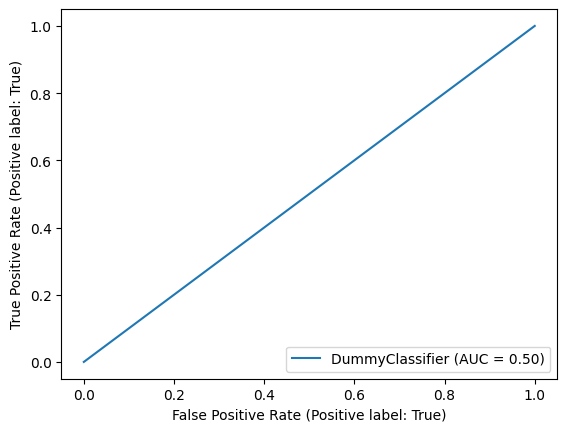

In [5]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train)
print(evaluate_model(dummy_classifier,
                     X_test=X_test,
                     y_test=y_test))

### Logistic Regression

/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     95391
        True       0.00      0.00      0.00      7129

    accuracy                           0.93    102520
   macro avg       0.47      0.50      0.48    102520
weighted avg       0.87      0.93      0.90    102520



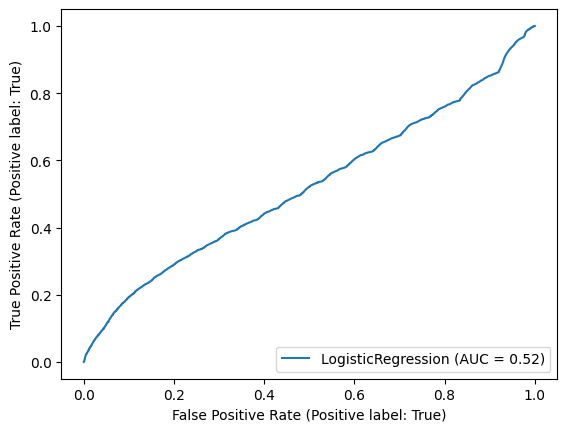

In [6]:
lr = linear_model.LogisticRegression()
lr.fit(X_train[['PublishYear', 'PagesNumber']], y_train)
evaluate_model(lr,
                     X_test=X_test[['PublishYear', 'PagesNumber']],
                     y_test=y_test)

## CountVectorizer

Let's introduce Scikit Learn Pipelines

In [7]:
model = create_pipeline()
model.fit(X_train.head(10000), y_train.head(10000))

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('description_bow',
                                                  CountVectorizer(max_df=0.05,
                                                                  min_df=50,
                                                                  stop_words={'english'}),
                                                  'Description'),
                                                 ('title_bow',
                                                  CountVectorizer(max_df=0.05,
                                                                  min_df=50,
                                                                  stop_words={'english'}),
                                                  'Name')])),
                ('svd', TruncatedSVD(n_components=50)),
                ('classifier', LogisticRegression(random_state=42))])

              precision    recall  f1-score   support

       False       0.93      0.99      0.96     95391
        True       0.39      0.06      0.10      7129

    accuracy                           0.93    102520
   macro avg       0.66      0.52      0.53    102520
weighted avg       0.90      0.93      0.90    102520



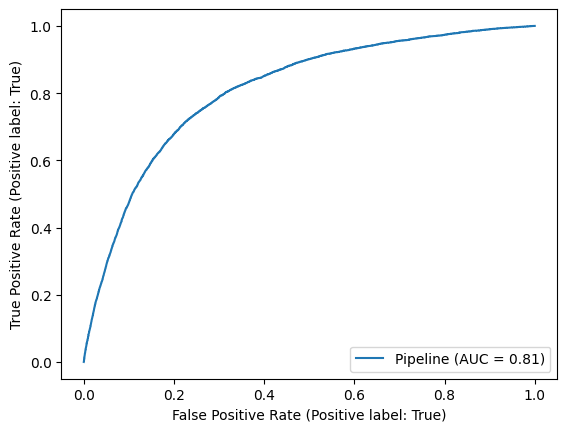

In [9]:
evaluate_model(model, X_test=X_test, y_test=y_test)

### Introducing GridsearchCV to explore hyperparameters

In [10]:
params = {
    'column_transformer__title_bow__min_df': (100, 500),
    'column_transformer__title_bow__max_df': (0.05, 0.1),
    'column_transformer__description_bow__min_df': (100, 500),
    'column_transformer__description_bow__max_df': (0.05, 0.1),
    'svd__n_components': (10, 50, 100)
}

random_search = RandomizedSearchCV(model, params, scoring='precision', n_jobs=-1, verbose=1)
random_search.fit(X_train.head(20000), y_train.head(20000))


random_search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.40306388731685844

In [11]:
random_search.best_params_

{'svd__n_components': 50,
 'column_transformer__title_bow__min_df': 100,
 'column_transformer__title_bow__max_df': 0.05,
 'column_transformer__description_bow__min_df': 500,
 'column_transformer__description_bow__max_df': 0.1}

In [12]:
final_model = create_pipeline(params=random_search.best_params_)

In [13]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('description_bow',
                                                  CountVectorizer(max_df=0.1,
                                                                  min_df=500,
                                                                  stop_words={'english'}),
                                                  'Description'),
                                                 ('title_bow',
                                                  CountVectorizer(max_df=0.05,
                                                                  min_df=100,
                                                                  stop_words={'english'}),
                                                  'Name')])),
                ('svd', TruncatedSVD(n_components=50)),
                ('classifier', LogisticRegression(random_state=42))])

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     95391
        True       0.41      0.04      0.08      7129

    accuracy                           0.93    102520
   macro avg       0.67      0.52      0.52    102520
weighted avg       0.90      0.93      0.90    102520



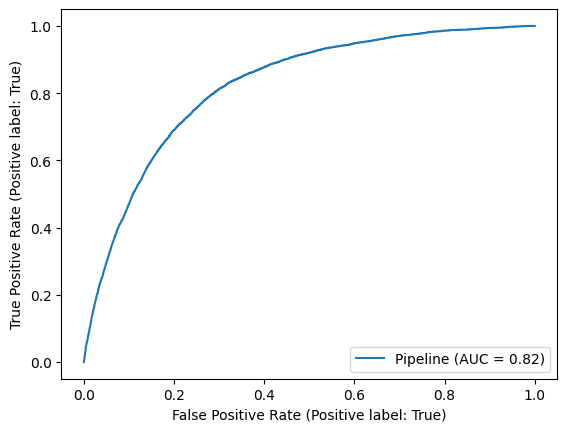

In [14]:
evaluate_model(final_model, X_test, y_test)

In [15]:
joblib.dump(final_model, '../models/final_model.clf')

['../models/final_model.clf']